In [1]:
import psycopg2

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 8]

from pprint import pprint

try:
  con
except NameError:
  con = psycopg2.connect(user="postgres", dbname="newrealadb", password="coap")
  con.set_session(readonly=True, autocommit=False)
    

In [2]:
exp_data_sql = """
SELECT 
    ex.exp_id,
    ex.num_trials, 
    d.dnid,
    n.*
FROM 
	experiment ex
  JOIN deployed_node d ON d.exp_id = ex.exp_id
  JOIN node n ON d.node_id = n.node_id
GROUP BY
	ex.exp_id,
    n.node_id,
    d.dnid
ORDER BY
  ex.attacker_rate,
  ex.proxy_connections
;
"""
lay_of_the_land = pd.read_sql_query(exp_data_sql, con)
con.commit()
print("\n".join(lay_of_the_land.exp_id.unique().tolist()))
lay_of_the_land

3client_0attacker_infinite_requests_many_trials_realAstatic_norouterproxy
2client_1attacker_infinite_requests_many_trials_realAstatic_norouterproxy
1client_0attacker_infinite_requests_many_trials_realAstatic_norouterproxy
2client_0attacker_infinite_requests_many_trials_realAstatic_norouterproxy
3client_1attacker_infinite_requests_many_trials_realAstatic_norouterproxy
1client_1attacker_infinite_requests_many_trials_realAstatic_norouterproxy


,exp_id,num_trials,dnid,node_id,node_name,hardware_type,operating_system
0,3client_0attacker_infinite_requests_many_trial...,3,21,2,receiver,pc3000,ubuntu1804-std
1,2client_1attacker_infinite_requests_many_trial...,3,32,7,client3,pc3000,ubuntu1804-std
2,1client_0attacker_infinite_requests_many_trial...,3,6,4,proxy,microcloud,ubuntu1804-std
3,3client_0attacker_infinite_requests_many_trial...,3,15,3,attacker,pc3000,ubuntu1804-std
4,1client_0attacker_infinite_requests_many_trial...,3,3,6,client2,pc3000,ubuntu1804-std
5,2client_0attacker_infinite_requests_many_trial...,3,8,3,attacker,pc3000,ubuntu1804-std
6,3client_1attacker_infinite_requests_many_trial...,3,41,4,proxy,microcloud,ubuntu1804-std
7,3client_1attacker_infinite_requests_many_trial...,3,40,1,originserver,pc2133,ubuntu1804-std
8,1client_1attacker_infinite_requests_many_trial...,3,27,4,proxy,microcloud,ubuntu1804-std
9,3client_1attacker_infinite_requests_many_trial...,3,38,6,client2,pc3000,ubuntu1804-std


In [3]:
client_rps_sql = """
WITH base_rps_table AS(
	SELECT
		d.exp_id,
		n.node_name,
		e.trial,
		COUNT(DISTINCT e.message_marker) AS sent_messages,
		MAX(e.observe_timestamp) - MIN(e.observe_timestamp) AS active_time_sec
	FROM
		deployed_node d
		JOIN node n ON n.node_id = d.node_id
		JOIN event e ON e.observer_id = d.dnid
		JOIN experiment ex ON ex.exp_id = d.exp_id
	WHERE
		n.node_name LIKE '%client%' OR
		n.node_name LIKE '%attacker%'
	GROUP BY
		d.exp_id,
		n.node_name,
		e.trial
)

SELECT *, sent_messages / active_time_sec AS average_rps
FROM base_rps_table;
"""

df = pd.read_sql_query(client_rps_sql, con)
con.commit()

# Add number of attackers and clients in the df
ndf = df.groupby(by=["exp_id"]).agg(
    has_attacker=("node_name", lambda x: int(any(x.str.startswith("attacker")))),
    num_clients=("node_name", lambda x: x.nunique() - any(x.str.startswith("attacker"))),
)
df = df.merge(ndf, on="exp_id")

df

,exp_id,node_name,trial,sent_messages,active_time_sec,average_rps,has_attacker,num_clients
0,1client_0attacker_infinite_requests_many_trial...,client1,1,1759,97.946896,17.958711,0,1
1,1client_0attacker_infinite_requests_many_trial...,client1,2,1758,97.927344,17.952085,0,1
2,1client_0attacker_infinite_requests_many_trial...,client1,3,1755,97.959307,17.915602,0,1
3,1client_1attacker_infinite_requests_many_trial...,attacker,1,175343,19.691358,8904.566115,1,1
4,1client_1attacker_infinite_requests_many_trial...,attacker,2,182331,19.749153,9232.345242,1,1
5,1client_1attacker_infinite_requests_many_trial...,attacker,3,175424,19.739986,8886.733785,1,1
6,1client_1attacker_infinite_requests_many_trial...,client1,1,372,85.984787,4.326347,1,1
7,1client_1attacker_infinite_requests_many_trial...,client1,2,366,96.126008,3.807502,1,1
8,1client_1attacker_infinite_requests_many_trial...,client1,3,367,95.562826,3.840405,1,1
9,2client_0attacker_infinite_requests_many_trial...,client1,1,1762,97.900424,17.997879,0,2


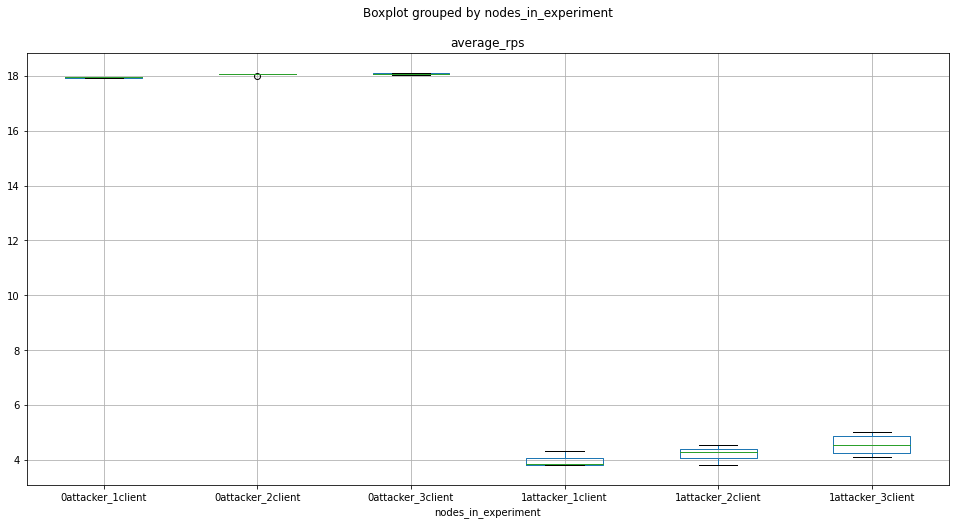

,exp_id,node_name,trial,sent_messages,active_time_sec,average_rps,has_attacker,num_clients,nodes_in_experiment,other_nodes_in_experiment
0,1client_0attacker_infinite_requests_many_trial...,client1,1,1759,97.946896,17.958711,0,1,0attacker_1client,1client_0attacker
1,1client_0attacker_infinite_requests_many_trial...,client1,2,1758,97.927344,17.952085,0,1,0attacker_1client,1client_0attacker
2,1client_0attacker_infinite_requests_many_trial...,client1,3,1755,97.959307,17.915602,0,1,0attacker_1client,1client_0attacker
3,1client_1attacker_infinite_requests_many_trial...,attacker,1,175343,19.691358,8904.566115,1,1,1attacker_1client,1client_1attacker
4,1client_1attacker_infinite_requests_many_trial...,attacker,2,182331,19.749153,9232.345242,1,1,1attacker_1client,1client_1attacker
5,1client_1attacker_infinite_requests_many_trial...,attacker,3,175424,19.739986,8886.733785,1,1,1attacker_1client,1client_1attacker
6,1client_1attacker_infinite_requests_many_trial...,client1,1,372,85.984787,4.326347,1,1,1attacker_1client,1client_1attacker
7,1client_1attacker_infinite_requests_many_trial...,client1,2,366,96.126008,3.807502,1,1,1attacker_1client,1client_1attacker
8,1client_1attacker_infinite_requests_many_trial...,client1,3,367,95.562826,3.840405,1,1,1attacker_1client,1client_1attacker
9,2client_0attacker_infinite_requests_many_trial...,client1,1,1762,97.900424,17.997879,0,2,0attacker_2client,2client_0attacker


In [4]:
df["nodes_in_experiment"] = df["has_attacker"].astype(str) + "attacker_" + df["num_clients"].astype(str) + "client"
df["other_nodes_in_experiment"] = df["num_clients"].astype(str) + "client_" + df["has_attacker"].astype(str) + "attacker"
tdf = df[df["node_name"] != "attacker"]
tdf.boxplot(by="nodes_in_experiment", column="average_rps")
plt.show()

tdf.groupby(by=["nodes_in_experiment"]).count()

df

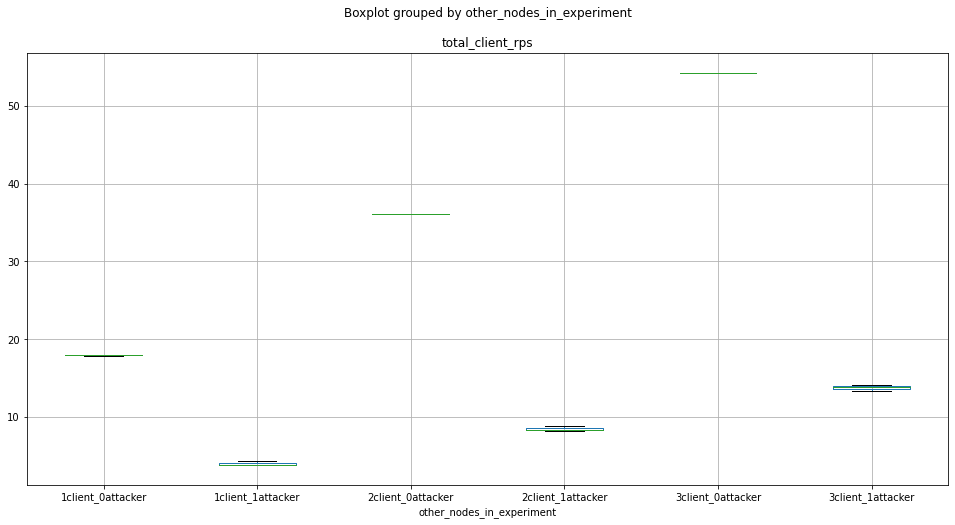

,exp_id,trial,total_client_rps,nodes_in_experiment,other_nodes_in_experiment
0,1client_0attacker_infinite_requests_many_trial...,1,17.958711,0attacker_1client,1client_0attacker
1,1client_0attacker_infinite_requests_many_trial...,2,17.952085,0attacker_1client,1client_0attacker
2,1client_0attacker_infinite_requests_many_trial...,3,17.915602,0attacker_1client,1client_0attacker
3,1client_1attacker_infinite_requests_many_trial...,1,4.326347,1attacker_1client,1client_1attacker
4,1client_1attacker_infinite_requests_many_trial...,2,3.807502,1attacker_1client,1client_1attacker
5,1client_1attacker_infinite_requests_many_trial...,3,3.840405,1attacker_1client,1client_1attacker
6,2client_0attacker_infinite_requests_many_trial...,1,36.078888,0attacker_2client,2client_0attacker
7,2client_0attacker_infinite_requests_many_trial...,2,36.123478,0attacker_2client,2client_0attacker
8,2client_0attacker_infinite_requests_many_trial...,3,36.094542,0attacker_2client,2client_0attacker
9,2client_1attacker_infinite_requests_many_trial...,1,8.876714,1attacker_2client,2client_1attacker


In [5]:
# total_client_df = tdf.groupby(by=["exp_id"]).agg(
#     total_client_rps=("average_rps", "sum"),
#     nodes_in_experiment=("nodes_in_experiment", "first"),
# ).reset_index()

# total_client_df.boxplot(by="nodes_in_experiment", column="total_client_rps")

# total_client_df

total_client_df = tdf.groupby(by=["exp_id", "trial"]).agg(
    total_client_rps=("average_rps", "sum"),
    nodes_in_experiment=("nodes_in_experiment", "first"),
    other_nodes_in_experiment=("other_nodes_in_experiment", "first"),
).reset_index()

total_client_df.boxplot(by="other_nodes_in_experiment", column="total_client_rps")
plt.show()

total_client_df